# Meteorology Data Extraction

In this notebook, we will:
1. Run code to associate sample plots (fields) with their nearest GridMET cell.
2. Extract GridMET bias-correction information from DRI's rasters.
3. Use a simple Python API that downloads GridMET data from the THREDDS server, and NLDAS-2 hourly precipitation data from NASA GES DISC.

- Read about GridMET: https://www.climatologylab.org/gridmet.html
- Read about NLDAS-2: https://ldas.gsfc.nasa.gov/nldas/nldas-2-model-data



In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import cartopy.crs as ccrs

# Set matplotlib to display inline
%matplotlib inline

Let's load the shapefile again.

In [ ]:
# Load the shapefile
root = os.path.abspath('../../..')
project_ws = os.path.join(root, 'examples', '1_Boulder')
data_dir = os.path.join(project_ws, 'data')
shapefile_dir = os.path.join(data_dir, 'gis')
shapefile_path = os.path.join(shapefile_dir, 'mt_sid_boulder.shp')
gdf = gpd.read_file(shapefile_path)

# Display the first few rows of the GeoDataFrame to examine structure and attributes
print(gdf.head())
print(gdf.shape[0], 'fields')

# Plot the shapefile geometries
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})  # Create GeoAxes

gdf.plot(ax=ax, edgecolor='black', transform=ccrs.epsg(5071))

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title('Fields Geometries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Our fields are in a pretty tight cluster. We're preparing to download meteorology from a 4-km resolution dataset (GridMET), so it's unnecessary to download a meteorology time series for each field, as many will just be copies. Rather, we'll identify the Gridmet 'cells' with a shapefile, and find the closest cell to each field, and download those. We will see we only need the meteorology data from four GridMET cells for all of the fields.

In addition to the raw meteorology data, we will also be accessing rasters that show the observed bias between Agrimet and Agrimet-like weather stations and GridMET's reference ET. These biases are due to the impacts of irrigated agriculture on the near-surface atmosphere, which often tends to see relatively high humidity and low temperature compared to arid and semi-arid surroundings. This bias is documented in Blankeneau (2019; https://doi.org/10.1016/j.agwat.2020.106376). The bias correction surfaces were mapped over CONUS by Desert Research Institute and OpenET and are documented in Melton et al., 2021 (https://doi.org/10.1111/1752-1688.12956). They are rasters in GridMET's native format.

Looking at the Gridmet grid, we see we will only need a few cell's data.

In [ ]:
# load the centroids
cetnroids_path = '../data/gis/gridmet_centroids.shp'
cdf = gpd.read_file(cetnroids_path)
print(cdf.head())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})  # Create GeoAxes

# Plot your shapefiles, specifying the CRS
cdf.plot(ax=ax, edgecolor='black', transform=ccrs.epsg(5071), color='red')  
gdf.plot(ax=ax, edgecolor='black', transform=ccrs.epsg(5071))

# Add basemap, reprojecting it to match your shapefiles' CRS
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title('Fields Geometries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The code in `assign_gridmet_and_corrections` associates each field with the nearest GridMET cell and pulls the bias-correction factor from the GeoTIFF bias correction surfaces. 

Note: the included bias-correction GeoTIFFs are projected in an equal area projection, EPSG 5071, as are the shapefiles we've been using. If the raster and shapefiles are not both in the same projection, the data extracted for the bias correction will be incorrect.

The code writes a new shapefile with the attribute 'GFID' which is the unique ID for each GridMET cell. It also writes a .json file with a dict that contains each month's bias correction factor for the field.

In [ ]:

sys.path.append('/')

# import the function from the module
from swimrs.data_extraction.gridmet.gridmet import assign_gridmet_and_corrections

# We must specify which column in the shapefile represents the field's unique ID, in this case it is 'FID_1'
FEATURE_ID = 'FID_1'

# run the GridMET-Field matching analysis, and pull the bias correction factors:
correction_tifs = os.path.join(data_dir, 'bias_correction_tif')

# same fields shapefile, but with the 'GFID' attribute added
fields_gridmet = os.path.join(shapefile_dir, 'mt_sid_boulder_gfid.shp')

# .json file with a dict of fieds and 12 bias correction factors each, one for each month
gridmet_factors = os.path.join(shapefile_dir, 'mt_sid_boulder_gfid.json')

In [ ]:
# run the code
assign_gridmet_and_corrections(fields=shapefile_path, 
                    gridmet_points=cetnroids_path, 
                    gridmet_ras=correction_tifs, 
                    fields_join=fields_gridmet, 
                    factors_js=gridmet_factors, 
                    feature_id=FEATURE_ID)

Note: This should print 'Get gridmet for 4 target points', as there should be only four unique GridMET cells that are closest each of the fields. 

Let's plot the fields colored according to the GFID, so we can assure ourselves this worked correctly:

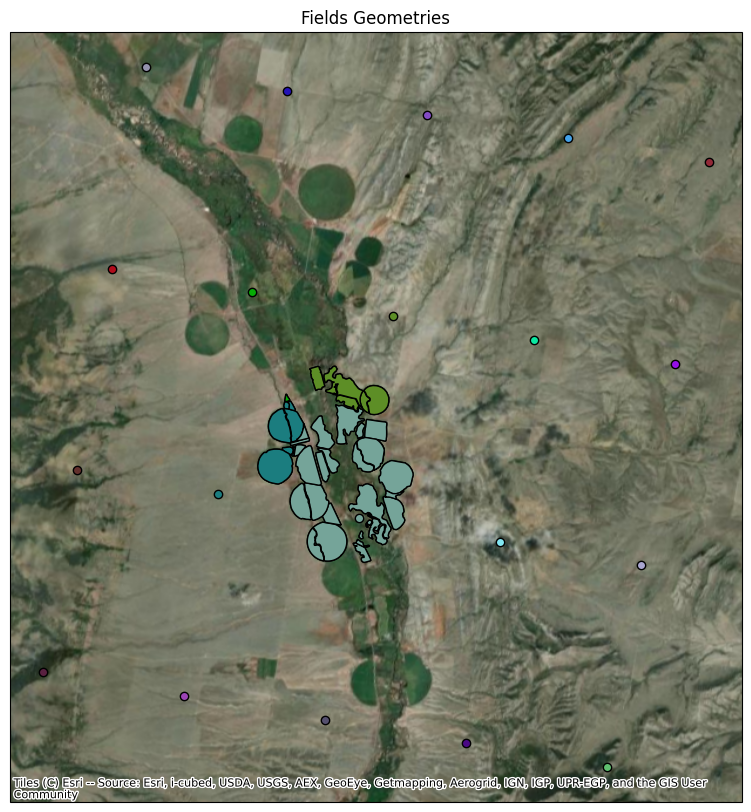

In [13]:
import matplotlib.pyplot as plt
import contextily as ctx
import cartopy.crs as ccrs
import random

# The following code raises a UserWarning that doesn't affect us, so we suppress it
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.") 

gdf_gfid = gpd.read_file(fields_gridmet)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})

# Get a list of unique GFID values
unique_gfids = set(cdf['GFID'].unique()).union(gdf_gfid['GFID'].unique())

# Generate a random color palette with enough colors for all unique GFIDs
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(unique_gfids))]

# Create a dictionary mapping GFID values to colors
color_map = dict(zip(unique_gfids, colors))

# Plot the shapefiles, using the color map to assign colors based on GFID
for gfid, color in color_map.items():
    cdf[cdf['GFID'] == gfid].plot(ax=ax, edgecolor='black', color=color, transform=ccrs.epsg(5071))
    gdf_gfid[gdf_gfid['GFID'] == gfid].plot(ax=ax, edgecolor='black', color=color, transform=ccrs.epsg(5071))

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title('Fields Geometries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

We can see that (hopefully) each field's color matches that of the nearest GridMET centroid. The 'GFID' for each field has been saved in the `'mt_sid_boulder_gfid.shp'`This reduces the data we must download by a large factor, and is especially important when we run this workflow on a sample with thousands of clustered fields. 

In [14]:
## TODO: add functionality and tutorial on using the GridMET .nc stack for extractions

Now, we have all we need to proceed with getting the daily meteorological timeseries from GridMET's THREDDS server. This is straightforward, using the `download_gridmet` function. This will probably take a few minutes.

Note: Under the hood, this code will also be downloading hourly precipitation data from NLDAS-2. This is helpful on days when there is precipitation and we want to know it's intensity for modeling purposes (to estimate runoff/recharge). While the NLDAS-2 data is in ~12 km resolution, we accept some data redundancy, and download a single NLDAS-2 time series at each GridMET cell, for simplicity's sake.

In [16]:
from swimrs.data_extraction.gridmet.gridmet import download_gridmet

met = 'met_timeseries'
if not os.path.isdir(met):
    os.mkdir(met)

download_gridmet(fields_gridmet, gridmet_factors, met, start='1987-01-01', end='2023-12-31',
                 target_fields=None, overwrite=False, feature_id=FEATURE_ID)

100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 4359.69it/s]


Okay, let's look at the one of the GridMET time series and see what we have.

In [19]:
met_data = os.path.join(met, 'gridmet_109803.csv')
met_df = pd.read_csv(met_data, index_col='date')
met_df.head()

,year,month,day,centroid_lat,centroid_lon,elev_m,tmin_c,tmax_c,etr_mm,eto_mm,...,prcp_hr_16,prcp_hr_17,prcp_hr_18,prcp_hr_19,prcp_hr_20,prcp_hr_21,prcp_hr_22,prcp_hr_23,etr_mm_uncorr,eto_mm_uncorr
date,,,,,,,,,,,,,,,,,,,,,
1987-01-01,1987,1,1,46.108,-111.933,1416.68,-13.949982,1.149994,1.492082,0.921087,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,1.3,0.8
1987-01-02,1987,1,2,46.108,-111.933,1416.68,-7.750000,4.950012,2.065959,1.266494,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,1.8,1.1
1987-01-03,1987,1,3,46.108,-111.933,1416.68,-10.049988,4.250000,2.065959,1.266494,...,0.0,0.0,0.0152,0.0000,0.0,0.0,0.0776,0.0,1.8,1.1
1987-01-04,1987,1,4,46.108,-111.933,1416.68,-4.850006,6.850006,1.606857,0.921087,...,0.0,0.0,0.0000,0.2128,0.0,0.0,0.0000,0.0,1.4,0.8
1987-01-05,1987,1,5,46.108,-111.933,1416.68,-7.750000,4.250000,1.492082,0.805951,...,0.0,0.0,0.0000,0.0036,0.0,0.0,0.0000,0.0,1.3,0.7


Here, we see we have information on the date, the location, and daily meteorological information from GridMET, including `tmin`, `tmax`, and `prcp_mm`. We see the critical reference ET estimates in 'uncorrected' form, `eto_mm_uncorr` and `etr_mm_uncorr`, which we could use in natural vegetation, and also in 'corrected' form, `eto_mm` and `etr_mm`, which we will be using over our irrigated study area. We also see `prcp_hr_XX`, which is the hourly NLDAS-2 precipitation estimate. 